In [1]:
import torch
import torchvision
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import DataLoader, RandomSampler

In [2]:
from dataset_utils import MNISTDataset

In [3]:
DEVICE = 'cuda'

IMG_SIZE = 32
BATCH_SIZE = 100

PATH_TO_MODEL = "models/diffusion_model_MNIST_50.pth"
DATASET = "MNIST"

BLOCKS = "res" # 'convNext', 'res'
IMPROVED_DDPM = False
ADAPTIVE_GN = False

### Dataset Loading

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMG_SIZE, IMG_SIZE)),
    torchvision.transforms.ToTensor(),
])


if DATASET == "MNIST":
    dataset = MNISTDataset(transform)
else:
    raise Exception("Currently works only with MNIST")
    

sampler = RandomSampler(dataset, num_samples = BATCH_SIZE)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, sampler = sampler)
imgs = next(iter(dataloader))[0]
IMG_CHANNELS = dataset[0][0].shape[0]

### Model Loading

In [5]:
from unet import UNet, DDPM, plot_samples

In [6]:
unet = UNet(IMG_CHANNELS, IMG_SIZE, block = BLOCKS, agn = ADAPTIVE_GN).to(DEVICE)
ddpm = DDPM(unet, T = 1000, cosine_schedule = IMPROVED_DDPM, device = DEVICE)

In [7]:
### Loading
unet.load_state_dict(torch.load(PATH_TO_MODEL))

<All keys matched successfully>

### Model Evaluation

In [8]:
def normalize(data):
    # Initialize a tensor to store the normalized images
    data_norm = torch.empty_like(data)

    # Iterate through each image in the batch
    for i in range(data.shape[0]):
        sample = data[i]
        sample_min = sample.min()
        sample_max = sample.max()

        # Normalize the image to range [0, 1]
        data_norm[i] = (sample - sample_min) / (sample_max - sample_min)
        
    return data_norm

In [9]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

In [10]:
samples = ddpm.sample(n_samples = BATCH_SIZE)
samples = normalize(samples)

Sampling...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:22<00:00,  3.80it/s]


SAMPLES


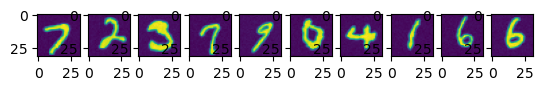

ORIGINAL IMAGES


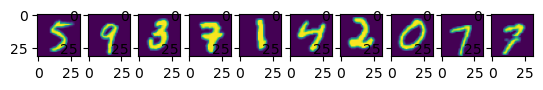

In [11]:
print("SAMPLES")
plot_samples(samples[10:20])
print("ORIGINAL IMAGES")
plot_samples(imgs[10:20])

In [23]:
from torcheval import metrics

fid = metrics.FrechetInceptionDistance(device = DEVICE) ## FID Score
fid.update(imgs.repeat(1,3,1,1), True)
fid.update(samples.repeat(1,3,1,1), False)
fid_score = fid.compute().detach().cpu().item()
print("FID Score:", fid_score)

FID Score: 45.439239501953125
